In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


The objective of this project is to segment customer data into meaningful classes, which convey a person's potential as a customer to a company based on the ecommerce-data dataset. The data is completely unlabelled, so to be able to segment customers into classes, an unsupervised model must be used. This unsupervised model must measure the meaningful features in the data to be able to then classify each customer into a group, based on their similar characteristics. Once the supervised model is done, we will then visualize these classes to be able to see how the model classified the people. 

This type of project is usually done by companies that want to know more about their customer base and how to better gain more customers in the future. The resulting classes are basically used to group people together so that companies could more effectively market their own companies to these groups using their specific traits. 

To start the project, We will do basic EDA on the dataset to get the basic features of the dataset, such as the names of columns and the types. We will also do data-cleaning to prevent potential errors in the model for the future. The data cleaning procedures will consist of dealing with null values by dropping them, which can affect how models are calculated negatively. We will also be dropping duplicates, which can be done for rows that are fully repeated and therefore, skew the data. Any columns that are not useful for analysis, like the description for example, will also be dropped to have compact dataframes with only useful features.

In [5]:
data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding="ISO-8859-1")
print(data.shape)
print(data.dtypes)

(541909, 8)
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
#find the number of duplicates in the training data
duplicates = data.duplicated().sum()
print(duplicates)


5268


In [9]:
missing_values_count = data.isnull().sum()
print(f' The number of missing values is :{missing_values_count}')
data.info()

 The number of missing values is :InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Number of Rows in the dataset: 541909
Number of empty customerID in the dataset: 135080


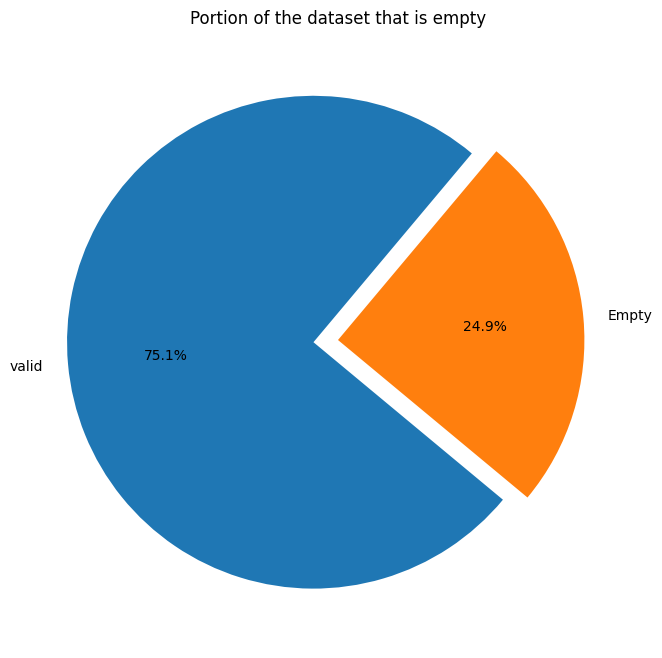

In [10]:
total_rows = data.shape[0]
empty_ids_count = (data['CustomerID'].isnull().sum())
valid_rows_count = total_rows - empty_ids_count
print(f"Number of Rows in the dataset: {total_rows}")
print(f"Number of empty customerID in the dataset: {empty_ids_count}") 


plt.figure(figsize=(8, 8))
plt.pie([valid_rows_count, empty_ids_count], explode=(0.1,0), labels=['valid', 'Empty'], autopct='%1.1f%%', startangle=50)
plt.title('Portion of the dataset that is empty')
plt.show()

There is a significant amount of customerID's that are missing, almost 25%. These are crucial for RFM, since the aim of RFM is to categorize individual customers. CustomerID's represent individual customers, so they cannot be categorized if they are unknown. You also cannot randomly assign customerID's to these rows because it might be the same customer making multiple purchases in multiple rows. There is no way to discern with the dataset if a customer made multiple purchases without the ID, so the best immediate option for an RFM analysis is to just drop the rows.

It is signficant because the portion that will be dropped is 25% of the dataset, which is a huge portion of data comprising of 135080 rows. This information would have otherwise been very useful for gaining information on classes of people in the dataset, however, RFM analysis requires the customer identification as a necessity. If RFM was not used to help segment the data, then the rows could have potentially been used in other ways.

for RFM analysis, we also do not need the description. So we will also be dropping the description column too, in order to potentially avoid having to drop useful rows for the RFM analysis.

In [11]:
## Drop Description column
rfm = data.drop('Description', axis=1)

## drop empty rows
rfm.dropna(inplace=True)

missing_values_count = rfm.isnull().sum()
print(f' The number of missing values is :{missing_values_count}')
rfm.info()

 The number of missing values is :InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Quantity     406829 non-null  int64  
 3   InvoiceDate  406829 non-null  object 
 4   UnitPrice    406829 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 24.8+ MB


Now we will calculate RFM, which is the Recency, Frequency, and Monetary value model used to segment customers by companies. This score ranks customers by three metrics. 

Recency is how recently a customers has bought a product. Frequency is how often a customer has bought a product. Monetary is how much the customer has spent buying products.

These measures are used to segment customers into sections corresponding to how good of a customer a person is to a business. It is a measure used to basically better understand the customer base of a company, which allows companies to better cater to their best customers or try to gain new ones.

In [12]:
# Calculate Recency
rfm['InvoiceDate'] = pd.to_datetime(rfm['InvoiceDate'], format='%m/%d/%Y %H:%M')
reference_date = (rfm['InvoiceDate'].max()) + pd.Timedelta(days=1)
recency_df = rfm.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days}).rename(columns={'InvoiceDate': 'Recency'})
recency_df.head()

,Recency
CustomerID,
12346.0,326
12347.0,2
12348.0,75
12349.0,19
12350.0,310


In [13]:
#calculate Frequency
frequency_df = rfm.groupby('CustomerID').agg({'Quantity': 'sum'}).rename(columns={'Quantity': 'Frequency'})
frequency_df.head()

,Frequency
CustomerID,
12346.0,0
12347.0,2458
12348.0,2341
12349.0,631
12350.0,197


In [14]:
#calculate Monetary
monetary_df = rfm.groupby('CustomerID').agg({'UnitPrice': 'sum'}).rename(columns={'UnitPrice': 'Monetary'})
monetary_df.head()

,Monetary
CustomerID,
12346.0,2.08
12347.0,481.21
12348.0,178.71
12349.0,605.10
12350.0,65.30


In [15]:
## merge the dataframes
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,0,2.08
12347.0,2,2458,481.21
12348.0,75,2341,178.71
12349.0,19,631,605.10
12350.0,310,197,65.30


The RFM metrics will be made into scores that rank the customers into different quartiles. The goal for RFM is basically finding out what customers to target with marketing. 

The Recency score ranks customers by their last purchase, with 1 being a customer that least recently purchased something and 4 being a customer who most recently purchased something. The point of recency is that someone who more recently bought something is better. 

The Frequency score ranks customers by how frequently they made a purchase, with 1 being customer that does not frequently buy products and 4 being a customer who very often purchases products. The point of Frequency is that someone who buys more products is better. 

The Monetary score ranks customers by how much money the spend, with 1 being customers that spend the lowest amount of money and 4 being the customers who spent the most money. The point of the Monetary metric for marketing is that someone who spends more money is better. 

These quartiles basically rank every customer into 4 tiers in each metric, with the overall RFM_Score given by summing the 3 metric scores being the overall best customers, hence the people that should be targeted for marketing so they can buy more products.

In [16]:
## Divide into rfm scores into quartiles. 
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=range(4, 0, -1))
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 4, labels=range(1, 5))
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=range(1, 5))
rfm_df.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12346.0,326,0,2.08,1,1,1
12347.0,2,2458,481.21,4,4,4
12348.0,75,2341,178.71,2,4,3
12349.0,19,631,605.10,3,3,4
12350.0,310,197,65.30,1,2,2


In [17]:
## calculate the rfm score and RFM segments.
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm_df.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,0,2.08,1,1,1,111,3
12347.0,2,2458,481.21,4,4,4,444,12
12348.0,75,2341,178.71,2,4,3,243,9
12349.0,19,631,605.10,3,3,4,334,10
12350.0,310,197,65.30,1,2,2,122,5


Since we now have the RFM score, we can now try to segment customers into different clusters.

We are going to be using an clustering algorithm to get the clusters needed. The clustering algorithm that will be used is kmeans because it is more computationally efficient than the other big potential clustering algorithm that can be used to analyze the RFM, hierarchical clustering. While hierarchical clustering has the advantage that it does not need a specific n_clusters specified upfront, it is less computationally efficient and also harder to interpret the results of hierarchical clustering, since it requires analysis of dendograms. 

Since we are using unsupervised models for analysis, there needs to be a way to judge how well each cluster segments the customer data. There is not any labels to be able to judge if the clusters are sensibly paired together. This means that metrics, such as silhouette score, must be used to judge the quality of the clustering. The silhouette score judges how similar an object is to its own cluster relative to the other clusters. To get the best scores, Kmeans will be run on a large range of n_clusters which the silhouette score calculated for each of the clusters.

In [18]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['R_Score', 'F_Score', 'M_Score']])

In [19]:
range_n_clusters = list(range(2, 60))
silhouette_avg_scores = []
wcss = []
## test to see which number of clusters is optimal using silhouette score
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=37, n_init='auto')
    cluster_labels = clusterer.fit_predict(rfm_scaled)
    silhouette = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette)
    wcss.append(clusterer.inertia_)
    print(f"For n_clusters = {n_clusters} The average silhouette_score is :  {silhouette}")

# Determine the optimal number of clusters based on the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
print(f"Optimal Number of Clusters based on silhouette score: {optimal_n_clusters}")

For n_clusters = 2 The average silhouette_score is :  0.4260837713539249
For n_clusters = 3 The average silhouette_score is :  0.33597574832961313
For n_clusters = 4 The average silhouette_score is :  0.3825262501183545
For n_clusters = 5 The average silhouette_score is :  0.3475539731920202
For n_clusters = 6 The average silhouette_score is :  0.35748891737176247
For n_clusters = 7 The average silhouette_score is :  0.3657172505880629
For n_clusters = 8 The average silhouette_score is :  0.3635483175313872
For n_clusters = 9 The average silhouette_score is :  0.37960515350370033
For n_clusters = 10 The average silhouette_score is :  0.3759973486224004
For n_clusters = 11 The average silhouette_score is :  0.40631735750964953
For n_clusters = 12 The average silhouette_score is :  0.42014855632372206
For n_clusters = 13 The average silhouette_score is :  0.4393616398344585
For n_clusters = 14 The average silhouette_score is :  0.44906311053241105
For n_clusters = 15 The average silhouet

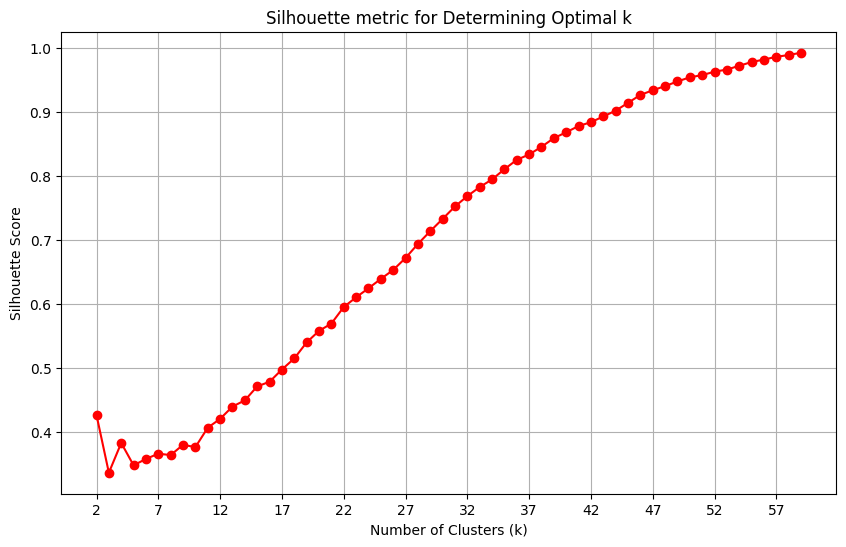

In [20]:
### Graph for silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 60), silhouette_avg_scores, marker='o', linestyle='-', color='red') 
plt.title('Silhouette metric for Determining Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 60, 5)) 
plt.grid(True)
plt.show()

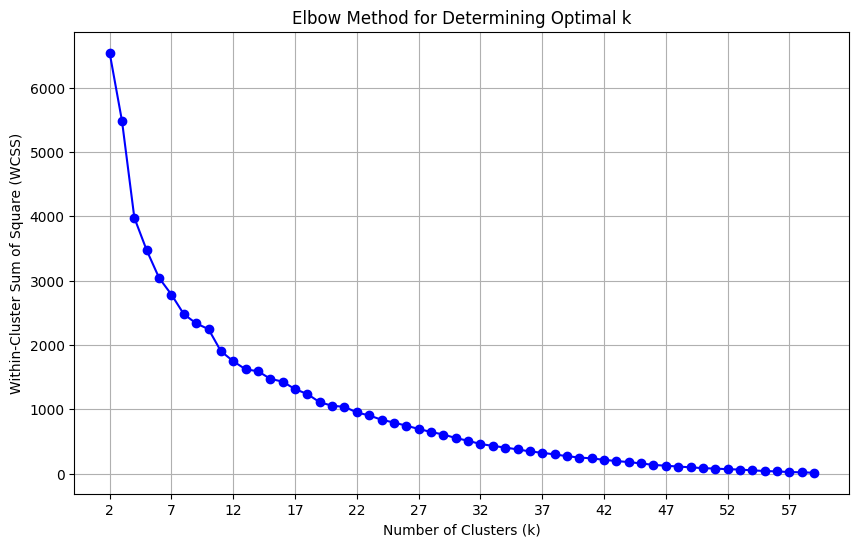

In [21]:
### Graph for elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 60), wcss, marker='o', linestyle='-', color='blue') 
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Square (WCSS)')
plt.xticks(range(2, 60, 5)) 
plt.grid(True)
plt.show()


We can reduce the dimensionality of the data to get a better look at the clusters. We can use the PCA technique to do this dimensional reduction and be able to visualize. I am gonna use 44 instead of the optimal clustering because it is difficult to actually assign characteristics to clusters otherwise.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


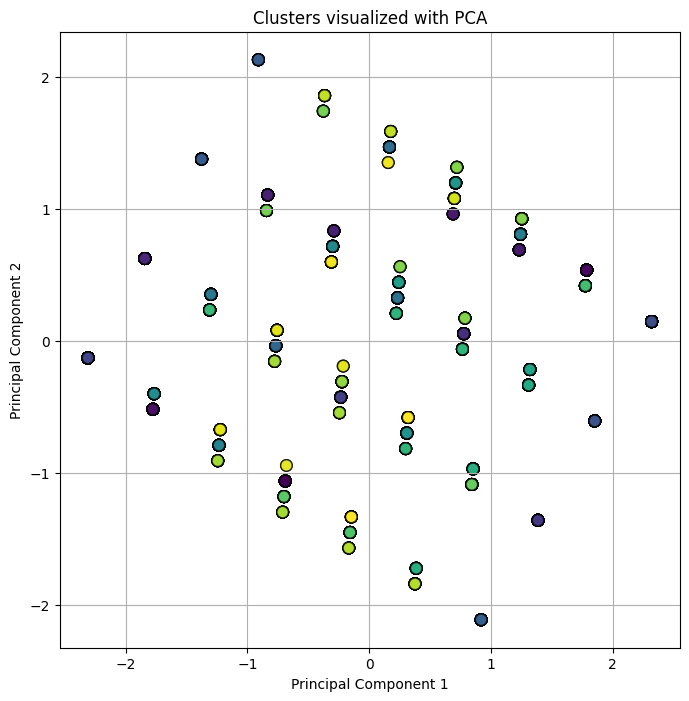

In [22]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Re-run KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=44, random_state=1)
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Plot clusters
plt.figure(figsize=(8, 8))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=70, alpha=0.7)
plt.title('Clusters visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

As can be seen above, all the clusters are neat and packed with their groups. They are basically uniform in how they are clustered. 

In [26]:
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_profile = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).reset_index()

print(cluster_profile)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   Cluster     Recency    Frequency     Monetary      
                  mean         mean         mean count
0        0    7.564516   266.532258   182.046290    62
1        1  256.829545    82.857955    84.626364   176
2        2    7.680000  2452.580000   223.836200   100
3        3  227.261905  1046.309524    24.920714    42
4        4   80.456140   540.491228   520.091930    57
5        5   29.704663  2977.461140   895.484352   193
6        6   82.290598   246.623932    86.116154   117
7        7   31.910112    78.438202    24.184719    89
8        8   31.043478   573.782609    91.281609    69
9        9    6.747664  5289.757009  1311.630047   428
10      10  265.593939    62.775758    23.464121   330
11      11   85.340000    81.100000    25.109533   150
12      12   96.915888  1874.420561   829.190850   107
13      13    8.857143    82.551020    21.929388    49
14      14   29.546763   631.964029   208.301583   139
15      15  220.755102   553.448980   204.244082    49
16      16

**Conclusion**


As can be seen above, the clusters have been made and now one can do analysis on the results. We have now segmented customers into 44 different groups, each with unique RFM values. For example, 29 has the huge shopping addicts who gained a 2000 frequency score, in which there are 70 people in that cluster.

Companies can now use this to target customers with specific actions. For example, they can target cluster 5 with 193 people who make up a mean frequency of 2977 so that they can go out and buy as often as they already are.

As can be seen, analytics are powerful. I learned about RFM during this project and I had no idea it existed before. Kmeans was perfect for this situation because it doesnt need labels to start finding patterns, hence why this was an unsupervised problem. Next time, I think it would interesting to run something like a regression to predict actions based on these statistics, since we only really discovered groupings but did not do any predictive analysis.

One thing I would change about this project is I would also plot the overall RFM score, since the overall RFM score basically ranks a customer overall. I would also explore potentially somehow keeping the item descriptions because they can potentially tell what kinds of items a customer might want to buy, though, that is beyond the scope of what this project does.

References:

https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp